In [16]:
import torch
import yaml 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import numpy as np

import mlflow

from model.VAE.pl_VAE import PlVAE
from dataset.datasetH5 import HDF5Dataset


# Params

In [17]:
dossier = "/projects/pnria/julien/autofill/runs/grid_ag_les_beta0.0001_etamin1e-07_ld64_bs64"
fichiers = [f for f in os.listdir(dossier) if os.path.isfile(os.path.join(dossier, f))]

print(fichiers)

['config_model.yaml', 'epoch=73-step=1593590.ckpt']


In [18]:
path_checkpoint = "/projects/pnria/julien/autofill/runs/grid_ag_saxs_beta0.0001_ld64_bs16/epoch=197-step=517968.ckpt"
path_config = "/projects/pnria/julien/autofill/runs/grid_ag_saxs_beta0.0001_ld64_bs16/config_model.yaml"

# Loading

In [19]:


with open(path_config, 'r') as file:
    config = yaml.safe_load(file)



In [20]:
config

{'dataset': {'conversion_dict_path': '/projects/pnria/DATA/AUTOFILL/v2/all_data_saxs_v2.json',
  'hdf5_file': '/projects/pnria/DATA/AUTOFILL/v2/all_data_saxs_v2.h5',
  'metadata_filters': {'material': ['ag'],
   'technique': ['saxs'],
   'type': ['simulation']},
  'requested_metadata': ['shape', 'material'],
  'sample_frac': 1.0,
  'transform': {'q': {'PaddingTransformer': {'pad_size': 500, 'value': 0}},
   'y': {'MinMaxNormalizer': {},
    'PaddingTransformer': {'pad_size': 500, 'value': 0}}}},
 'devices': '1',
 'experiment_name': 'grid_ag_saxs_beta0.0001_ld64_bs16',
 'model': {'args': {'dilation': 1,
   'down_channels': [16, 32, 64, 128, 256, 512],
   'in_channels': 1,
   'input_dim': 500,
   'latent_dim': 64,
   'output_channels': 1,
   'strat': 'y',
   'up_channels': [512, 256, 128, 64, 32, 16]},
  'output_transform_log': True,
  'vae_class': 'ResVAE'},
 'name': 'saxs_ag_gpu1',
 'training': {'T_max': 200,
  'batch_size': 16,
  'beta': 0.0001,
  'eta_min': 1e-08,
  'max_lr': 0.0001,

# Model

In [21]:
model = PlVAE(config)

In [22]:
checkpoint = torch.load(path_checkpoint, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# Dataset

In [23]:
dataset = HDF5Dataset(
hdf5_file = config["dataset"]["hdf5_file"],
metadata_filters = config["dataset"]["metadata_filters"],
conversion_dict_path = config["dataset"]["conversion_dict_path"],
sample_frac = config["dataset"]["sample_frac"],
transform =  config["dataset"]["transform"],
requested_metadata =  config["dataset"]["requested_metadata"],
)
print("========================================")

Applying filters: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

In [24]:
len(dataset)

52302

# Plot

In [25]:
def plot(idx_sample, tech="saxs"):
    one_sample = dataset[idx_sample]
    
    one_sample = {k:v.unsqueeze(0) if ("data_" in k and not "min" in k and not "max" in k) else v for k,v in one_sample.items()}
    output = model(one_sample)
    x = one_sample["data_y"]
    recon = output["recon"]

    recon = recon.detach().numpy().flatten()
    recon = recon*(one_sample["data_y_max"] - one_sample["data_y_min"]) + one_sample["data_y_min"]

    x = x.detach().numpy().flatten()
    x = x*(one_sample["data_y_max"] - one_sample["data_y_min"]) + one_sample["data_y_min"]
    print(x.max())

    plt.figure(figsize=(15,8))
    if tech == "saxs" :
        print("here")
        plt.loglog(x, label="truth")
        plt.loglog(recon, label="pred recon")
    else :
        plt.plot(x, label="truth")
        plt.plot(recon, label="pred recon")
    plt.title("Plot")
    plt.legend()
    plt.tight_layout()
    plt.show()

0.3921756
here


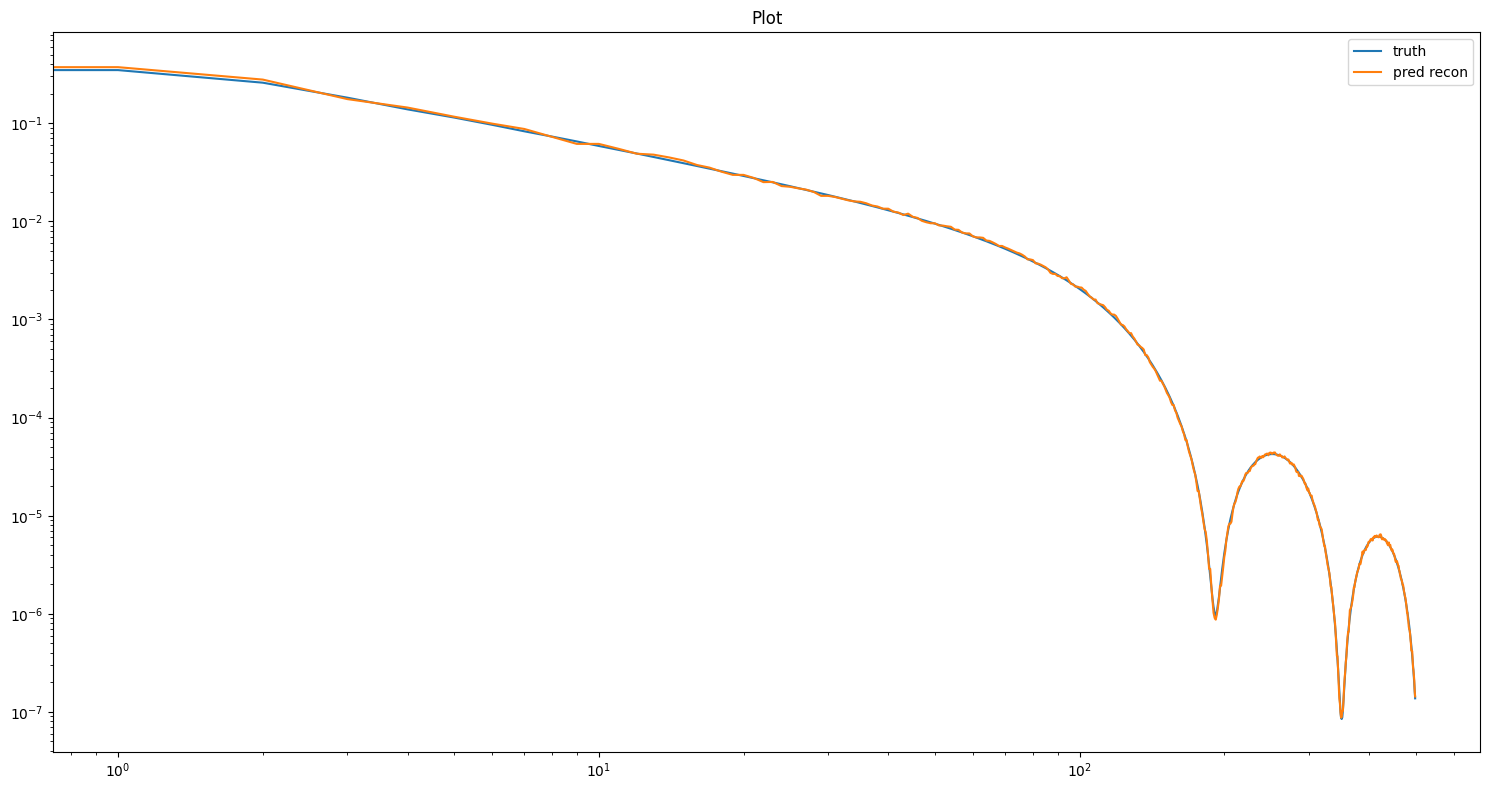

In [26]:
plot(14)

0.004161932
here


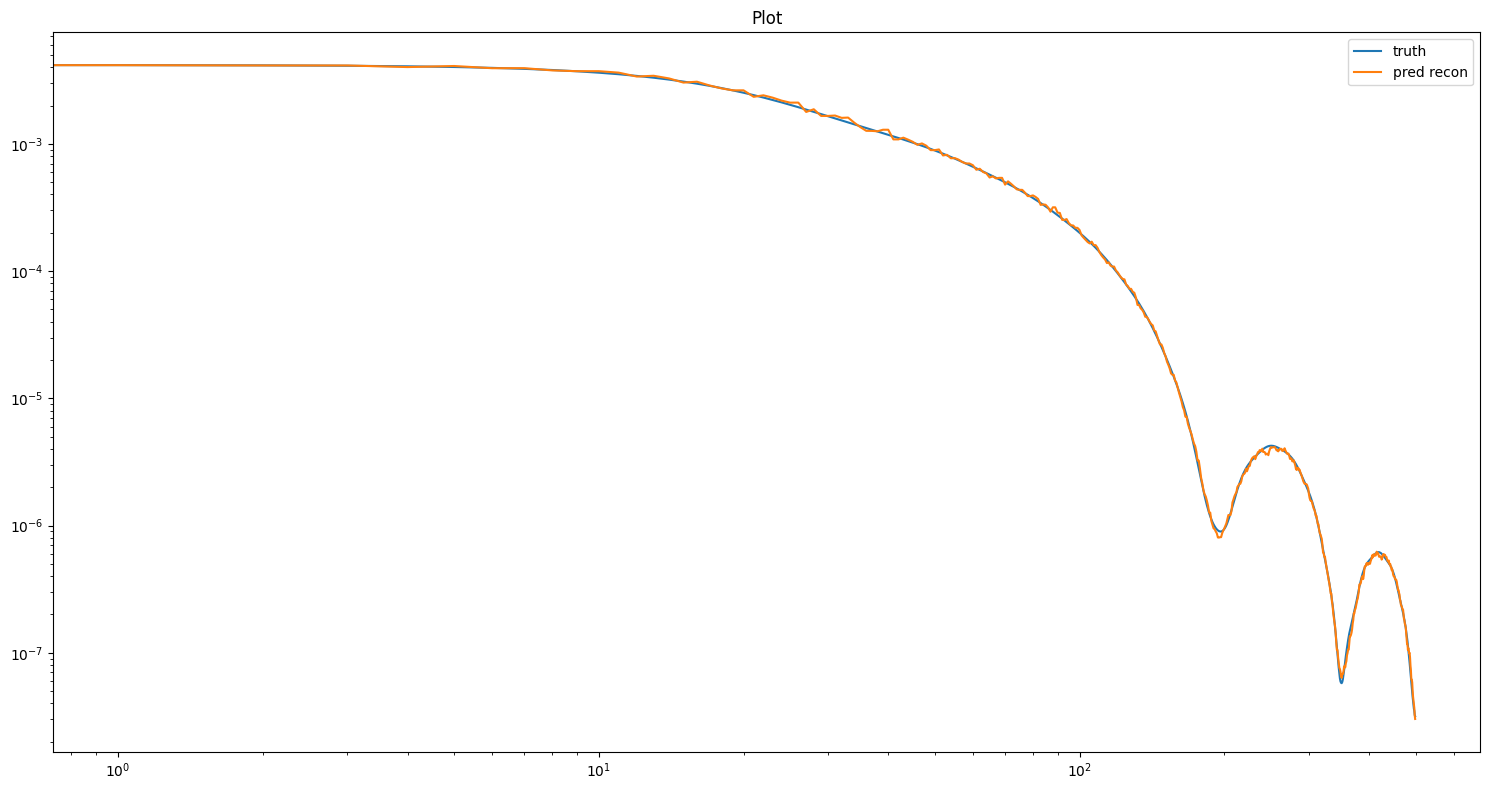

In [27]:
plot(19)

270.8941
here


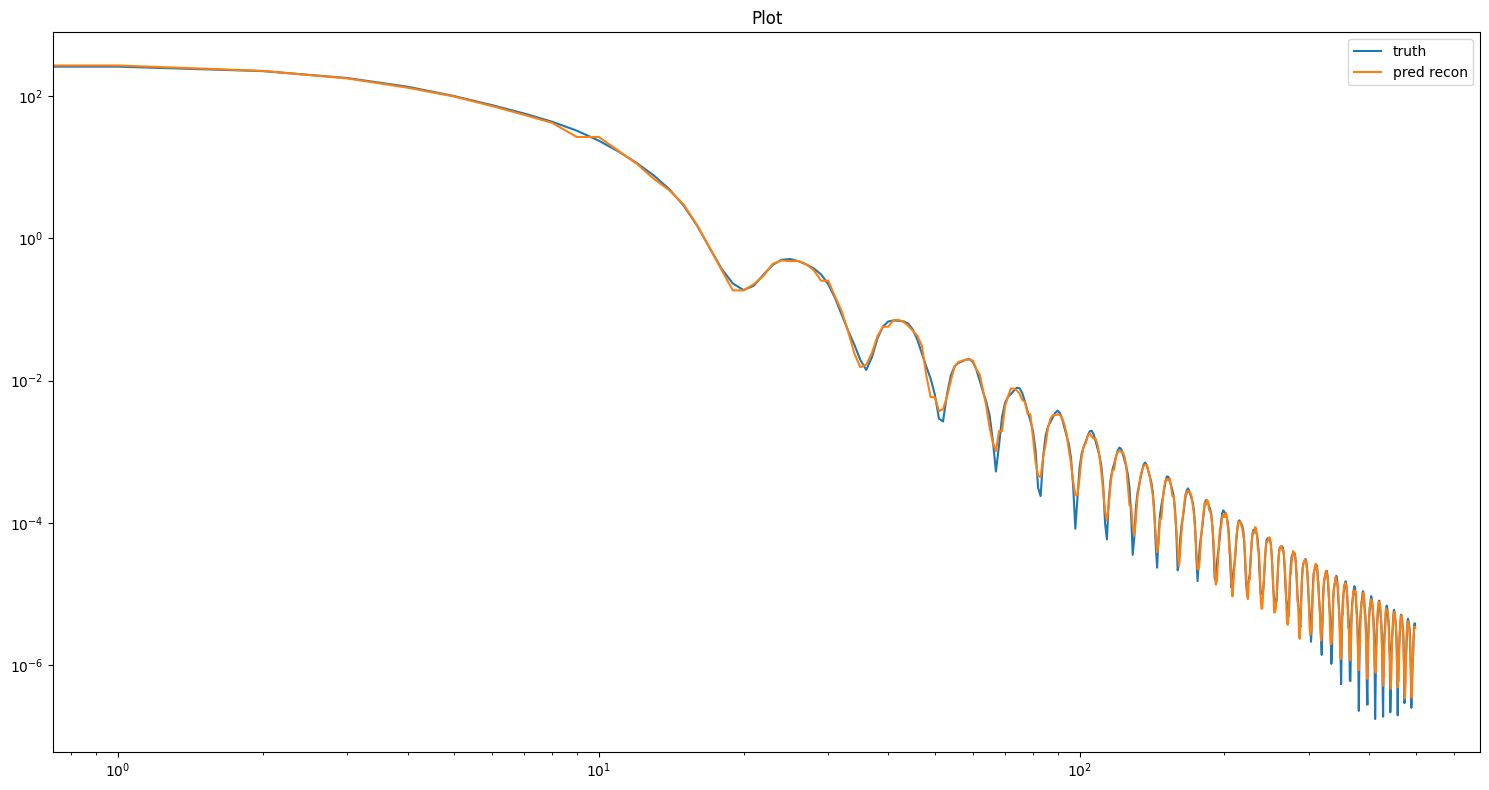

In [28]:
plot(789)

491.8077
here


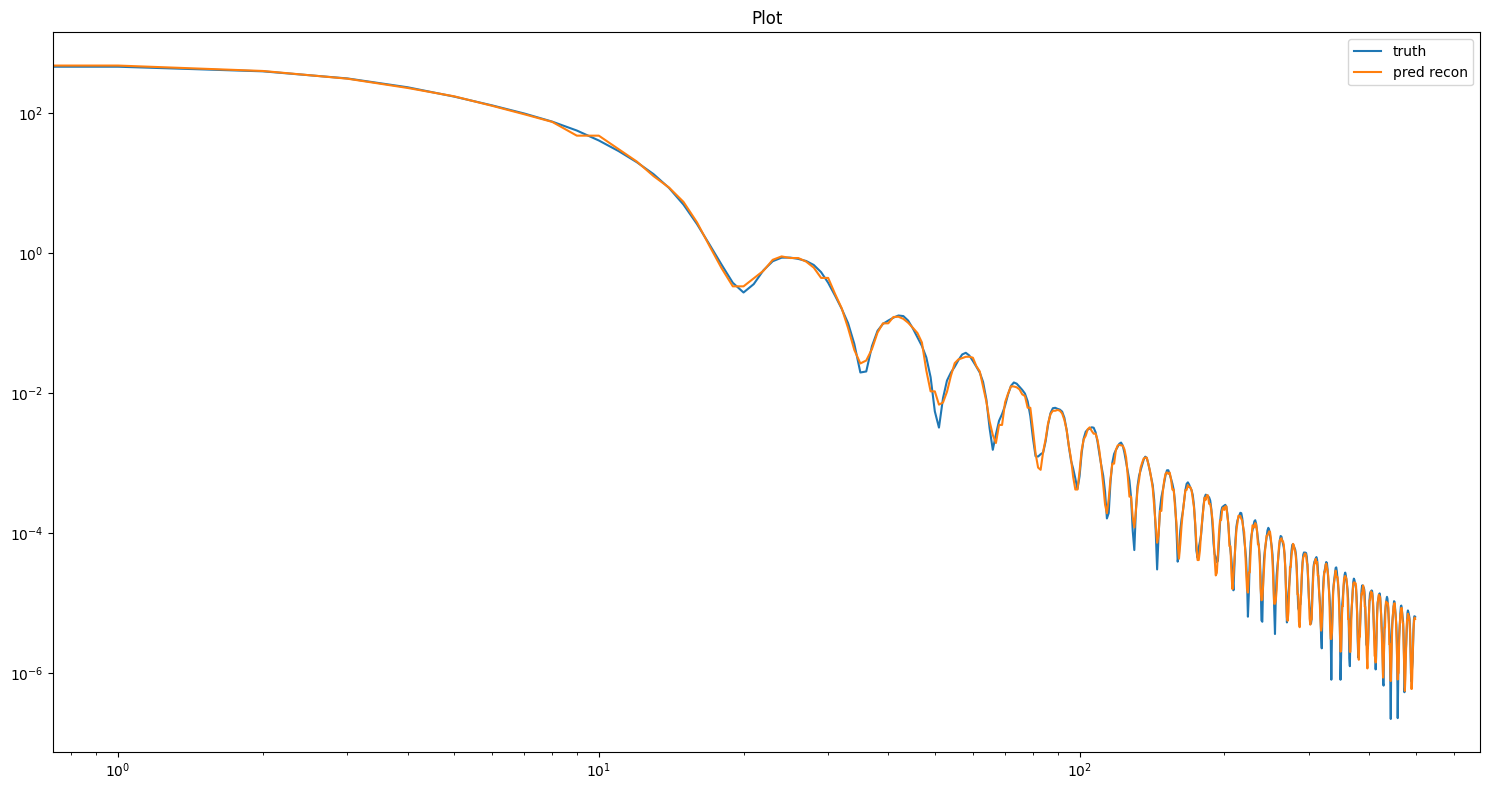

In [29]:
plot(800)

0.01912539
here


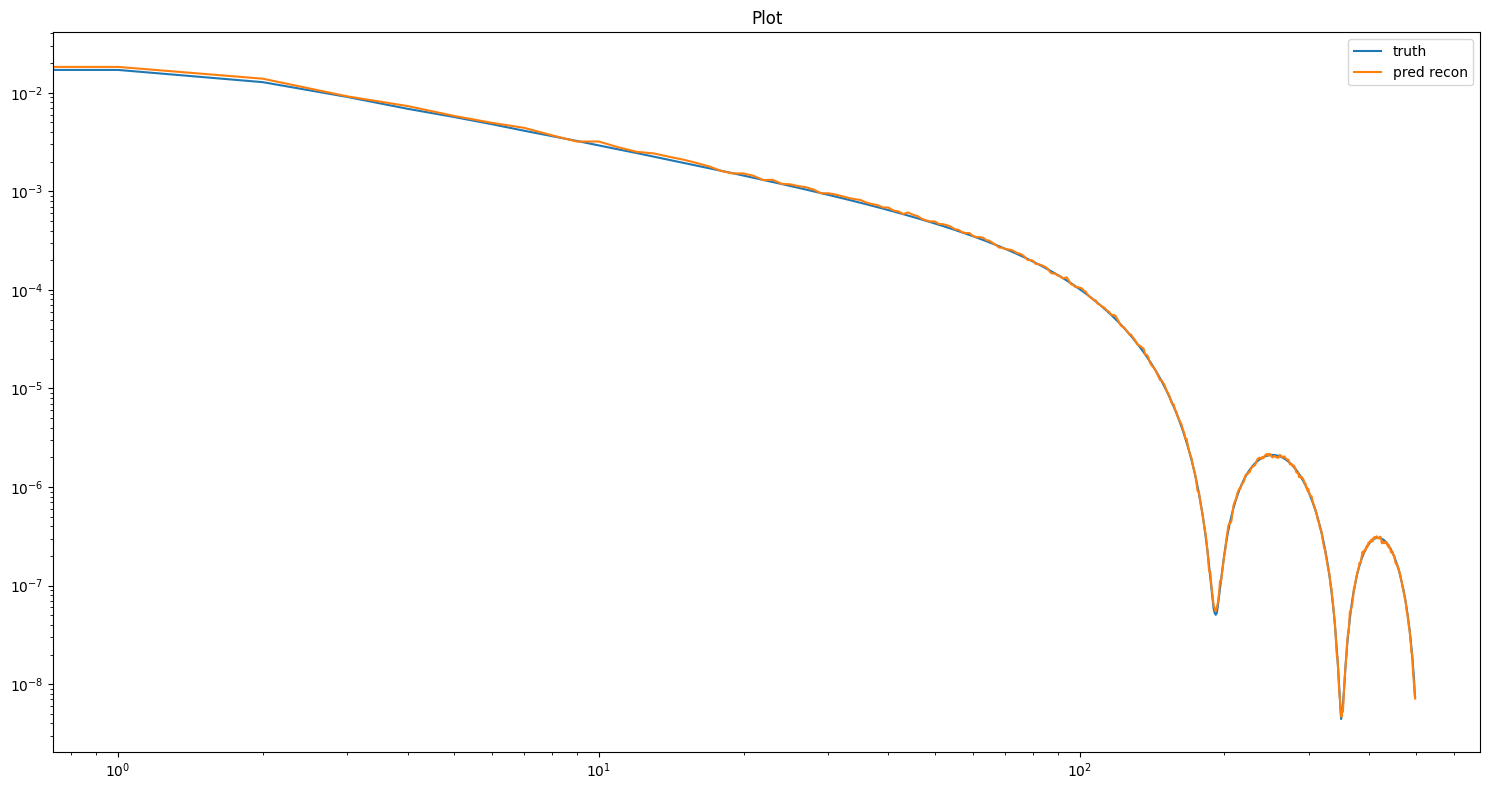

In [30]:
plot(491)

0.178668
here


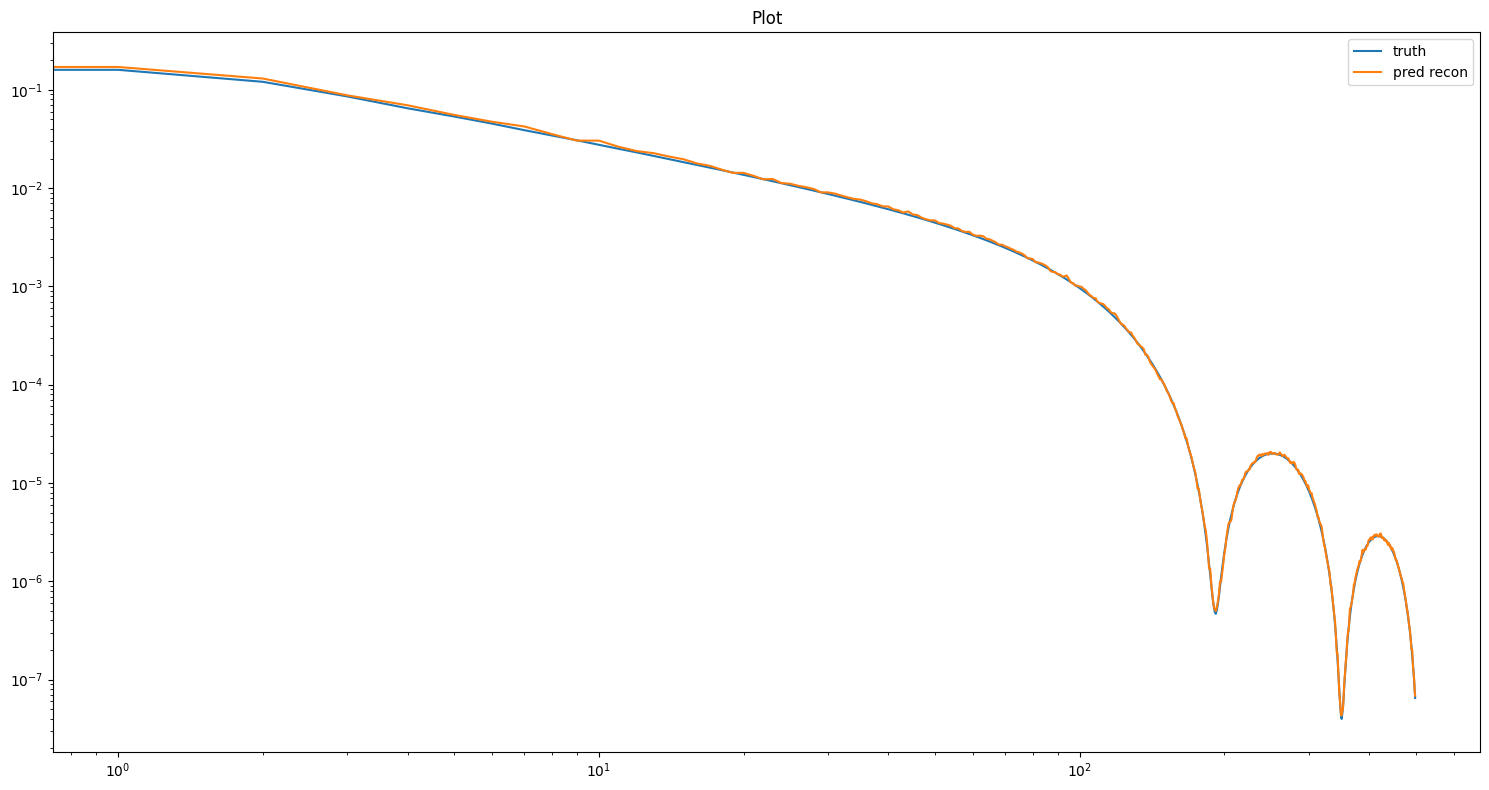

In [31]:
plot(485)

In [ ]:
plot(756)

In [ ]:
plot(409)